## Importação das Bibliotecas

In [25]:
# Pacotes de preparação de dados
import numpy as np
import pandas as pd

# Pacotes gráficos
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Pacotes de modelagem
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import chi2, f_classif

# Funções customizadas
from libs import analise_dados

## Importação da base de dados

In [44]:
xlsx = pd.ExcelFile('../data/raw/base-seguros.xlsx')
df = xlsx.parse('Base')
df.head()

,Flag_Renovou,Idade,Perfil_Risco,Diferenca_Perfil,Genero,Profissao,Tempo_Apolice,Uso_Veiculo,Qte_Apolices,Premio_Final,Premio_Qte_Parc,Premio_Pago_Ult,Premio_Mercado,Premio_Orig,Veic_Idade,Veic_Idade_Compra,Veic_Garagem,Veic_Potencia,Veic_Regiao
0,0,38,stable,only partner,Male,normal,1,private or freelance work,1,232.46,4 per year,232.47,221.56,243.59,9,8,private garage,225 kW,Reg7
1,1,35,stable,same,Male,normal,1,private or freelance work,1,208.53,4 per year,208.54,247.56,208.54,15,7,private garage,100 kW,Reg4
2,1,29,stable,same,Male,normal,0,private or freelance work,1,277.34,1 per year,277.35,293.32,277.35,14,6,underground garage,100 kW,Reg7
3,0,33,down,same,Female,medical,2,private or freelance work,1,239.51,4 per year,244.40,310.91,219.95,17,10,street,75 kW,Reg5
4,0,50,stable,same,Male,normal,8,unknown,1,554.54,4 per year,554.55,365.46,519.50,16,8,street,75 kW,Reg14


## Desenvolvimento dos modelos

### Regressão Logistica

#### Verificando a linearidade com Box-Tidwell

In [45]:
df_box_tidwell = df.copy()

df_box_tidwell = df_box_tidwell[['Idade', 'Tempo_Apolice', 'Qte_Apolices', 'Premio_Final', 'Premio_Pago_Ult', 'Premio_Mercado', 'Premio_Orig', 'Veic_Idade', 'Veic_Idade_Compra']]

for col in df_box_tidwell:
    df_box_tidwell[f'{col}_log'] = df_box_tidwell[col].apply(lambda x: np.log(x + 1))

X = df_box_tidwell
X = add_constant(X)
y = df['Flag_Renovou']

model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.375442
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Flag_Renovou   No. Observations:                23060
Model:                          Logit   Df Residuals:                    23041
Method:                           MLE   Df Model:                           18
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                 0.01912
Time:                        11:06:54   Log-Likelihood:                -8657.7
converged:                       True   LL-Null:                       -8826.4
Covariance Type:            nonrobust   LLR p-value:                 8.867e-61
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.9635      1.510     -1.300      0.194      -4.924       0.

Apenas as variáveis `Veic_Idade_Compra_log` e `Premio_Orig_log` apresentam um diferença significativa, logo iremos retirar do modelo

In [46]:
df_log = df.copy()
df_log.drop(['Veic_Idade_Compra', 'Premio_Orig'], axis=1, inplace=True)

### *Features Engineering*

#### Razão Potencia x Idade

In [47]:
df_log['Veic_Potencia (kW)'] = df_log['Veic_Potencia'].str.replace(' kW', '')
df_log['Veic_Potencia (kW)'] = df_log['Veic_Potencia (kW)'].str.replace('25-50', '50')
df_log['Veic_Potencia (kW)'] = df_log['Veic_Potencia (kW)'].str.replace('125-300', '200')
df_log['Veic_Potencia (kW)'] = df_log['Veic_Potencia (kW)'].astype(int)
df_log['Idade_Potencia'] = df_log['Veic_Potencia (kW)']/df_log['Idade']
df_log.head()

,Flag_Renovou,Idade,Perfil_Risco,Diferenca_Perfil,Genero,Profissao,Tempo_Apolice,Uso_Veiculo,Qte_Apolices,Premio_Final,Premio_Qte_Parc,Premio_Pago_Ult,Premio_Mercado,Veic_Idade,Veic_Garagem,Veic_Potencia,Veic_Regiao,Veic_Potencia (kW),Idade_Potencia
0,0,38,stable,only partner,Male,normal,1,private or freelance work,1,232.46,4 per year,232.47,221.56,9,private garage,225 kW,Reg7,225,5.921053
1,1,35,stable,same,Male,normal,1,private or freelance work,1,208.53,4 per year,208.54,247.56,15,private garage,100 kW,Reg4,100,2.857143
2,1,29,stable,same,Male,normal,0,private or freelance work,1,277.34,1 per year,277.35,293.32,14,underground garage,100 kW,Reg7,100,3.448276
3,0,33,down,same,Female,medical,2,private or freelance work,1,239.51,4 per year,244.40,310.91,17,street,75 kW,Reg5,75,2.272727
4,0,50,stable,same,Male,normal,8,unknown,1,554.54,4 per year,554.55,365.46,16,street,75 kW,Reg14,75,1.500000


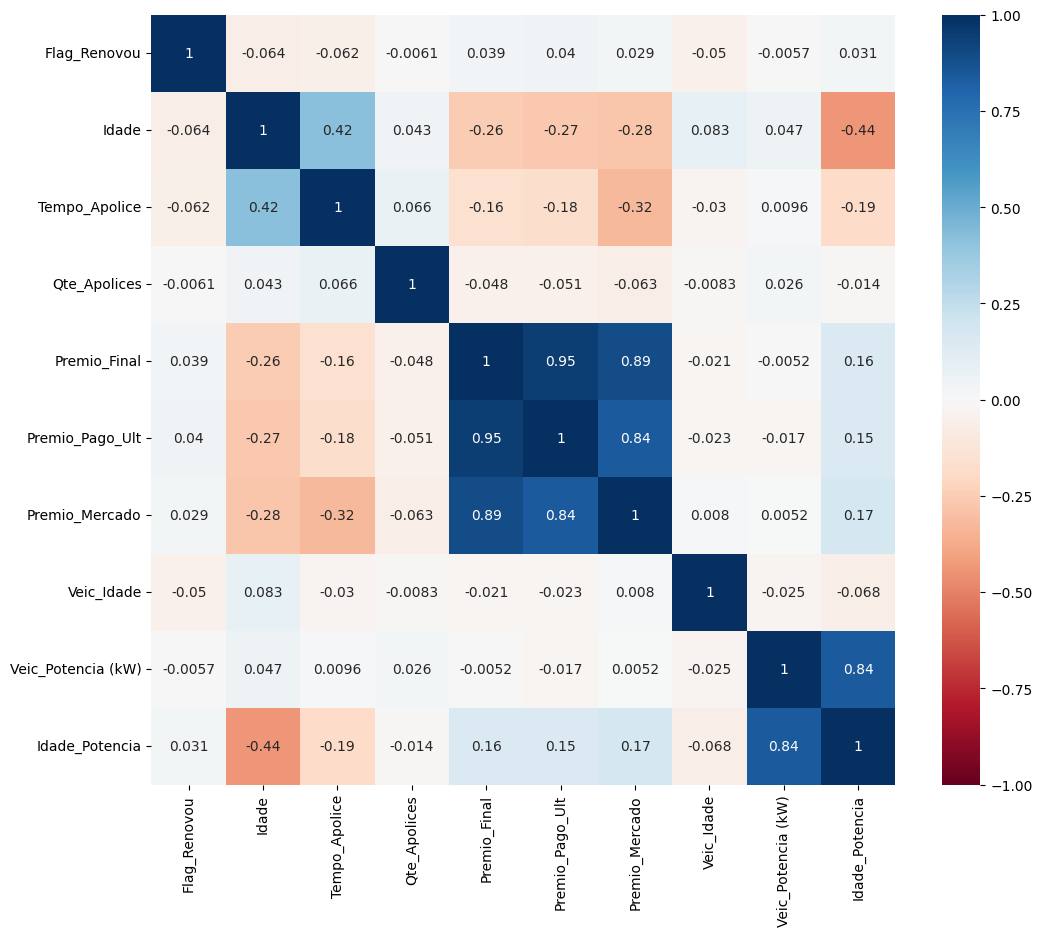

In [48]:
plt.figure(figsize=(12,10))
sns.heatmap(df_log.corr(numeric_only=True), annot=True, cmap='RdBu', vmax=1, vmin=-1);

Para evitar problemas de multicolineariedade, iremos retirar: `Idade`, `Premio_Mercado` e `Premio_Pago_Ult`.

Também iremos retirar as features usadas para criar a nova feature `Idade_Potencia`. 

In [49]:
df_log.drop(['Idade', 'Premio_Mercado', 'Premio_Pago_Ult'], axis=1, inplace=True)

In [50]:
df_log.drop(['Profissao', 'Veic_Potencia', 'Veic_Potencia (kW)', 'Veic_Garagem', 'Genero', 'Qte_Apolices'], axis=1, inplace=True)

#### Ajuste

In [51]:
y = df_log['Flag_Renovou']
x = df_log.drop('Flag_Renovou', axis=1)

x = pd.get_dummies(x, drop_first=True, dtype=int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

lr_model = LogisticRegression(random_state=42, max_iter=4000, class_weight='balanced')
lr_model.fit(x_train, y_train)

analise_dados.calcula_desempenho(lr_model, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.589332,0.594825,0.01
AUROC,0.623563,0.622943,-0.00
KS,0.179981,0.188165,0.05
Precision,0.173677,0.177006,0.02
Recall,0.587325,0.591883,0.01
F1,0.268080,0.272515,0.02


##### Utilizando SMOTE

In [52]:
smote = SMOTE(sampling_strategy=0.2, random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

lr_model.fit(x_train_smote, y_train_smote)

analise_dados.calcula_desempenho(lr_model, x_train_smote, y_train_smote, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.707756,0.698612,-0.01
AUROC,0.707314,0.613666,-0.13
KS,0.294636,0.180441,-0.39
Precision,0.296488,0.186715,-0.37
Recall,0.548845,0.402480,-0.27
F1,0.384999,0.255091,-0.34


##### Utilizando TomekLinks

In [53]:
tomek = TomekLinks(n_jobs=4)
x_train_tomek, y_train_tomek = tomek.fit_resample(x_train, y_train)

lr_model.fit(x_train_tomek, y_train_tomek)

analise_dados.calcula_desempenho(lr_model, x_train_tomek, y_train_tomek, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.589754,0.592512,0.00
AUROC,0.627909,0.623077,-0.01
KS,0.184768,0.191717,0.04
Precision,0.184634,0.177139,-0.04
Recall,0.594098,0.597520,0.01
F1,0.281716,0.273266,-0.03


##### Combinando as técnicas de reamostragem

In [54]:
# IMPORTANTE: a reamostragem deve ser feita APENAS na base de Treino
smote_tomek = SMOTETomek(sampling_strategy='auto', 
                                          random_state=42,
                                          smote=smote,
                                          tomek=tomek,
                                          n_jobs=-1)
x_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(x_train, y_train)

lr_model.fit(x_train_smote_tomek, y_train_smote_tomek)

analise_dados.calcula_desempenho(lr_model, x_train_smote_tomek, y_train_smote_tomek, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.707347,0.696155,-0.02
AUROC,0.709433,0.613845,-0.13
KS,0.298345,0.178750,-0.40
Precision,0.307540,0.187661,-0.39
Recall,0.552043,0.411499,-0.25
F1,0.395018,0.257768,-0.35


## Árvores de Decisão

### Ajuste

### Baseline

In [55]:
dt_model = DecisionTreeClassifier(max_depth=9, min_samples_leaf=20, random_state=42, class_weight='balanced')

dt_model.fit(x_train, y_train)

analise_dados.calcula_desempenho(dt_model, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.612006,0.583117,-0.05
AUROC,0.702047,0.576215,-0.18
KS,0.296648,0.123642,-0.58
Precision,0.203589,0.160027,-0.21
Recall,0.697146,0.529876,-0.24
F1,0.315145,0.245816,-0.22


##### Utilizando SMOTE

In [56]:
smote = SMOTE(sampling_strategy=0.2, random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

dt_model.fit(x_train_smote, y_train_smote)

analise_dados.calcula_desempenho(dt_model, x_train_smote, y_train_smote, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.630195,0.583261,-0.07
AUROC,0.734900,0.574964,-0.22
KS,0.328597,0.118673,-0.64
Precision,0.270009,0.157985,-0.41
Recall,0.715453,0.519729,-0.27
F1,0.392058,0.242313,-0.38


##### Utilizando TomekLinks

In [57]:
tomek = TomekLinks(n_jobs=4)
x_train_tomek, y_train_tomek = tomek.fit_resample(x_train, y_train)

dt_model.fit(x_train_tomek, y_train_tomek)

analise_dados.calcula_desempenho(dt_model, x_train_tomek, y_train_tomek, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.591850,0.558254,-0.06
AUROC,0.710971,0.579752,-0.18
KS,0.305145,0.137510,-0.55
Precision,0.211103,0.157994,-0.25
Recall,0.735849,0.564825,-0.23
F1,0.328085,0.246920,-0.25


##### Combinando as técnicas de reamostragem

In [58]:
# IMPORTANTE: a reamostragem deve ser feita APENAS na base de Treino
smote_tomek = SMOTETomek(sampling_strategy='auto', 
                                          random_state=42,
                                          smote=smote,
                                          tomek=tomek,
                                          n_jobs=-1)
x_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(x_train, y_train)

dt_model.fit(x_train_smote_tomek, y_train_smote_tomek)

analise_dados.calcula_desempenho(dt_model, x_train_smote_tomek, y_train_smote_tomek, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.631540,0.577913,-0.08
AUROC,0.737511,0.584000,-0.21
KS,0.333925,0.126225,-0.62
Precision,0.280464,0.158319,-0.44
Recall,0.721137,0.531003,-0.26
F1,0.403860,0.243915,-0.40


## Modelo Baseline

Apesar dos modelos apresentarem um alto overfitting, iremos utilizar como baseline o modelo base da regressão logística.

In [59]:
lr_model.fit(x_train, y_train)

analise_dados.calcula_desempenho(lr_model, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.589332,0.594825,0.01
AUROC,0.623563,0.622943,-0.00
KS,0.179981,0.188165,0.05
Precision,0.173677,0.177006,0.02
Recall,0.587325,0.591883,0.01
F1,0.268080,0.272515,0.02


## Modelos Ensemble

### Bagging Classifier

In [60]:
bagging_model = BaggingClassifier(estimator=lr_model,
                                  n_estimators=100, 
                                  max_samples=0.5,
                                  max_features=0.5,
                                  random_state=42)

bagging_model.fit(x_train, y_train)

analise_dados.calcula_desempenho(bagging_model, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.562508,0.571408,0.02
AUROC,0.617698,0.622626,0.01
KS,0.172198,0.191782,0.11
Precision,0.168371,0.173270,0.03
Recall,0.613449,0.621195,0.01
F1,0.264222,0.270961,0.03


### GradientBoosting

In [61]:
gb_model = GradientBoostingClassifier(n_estimators=200,
                                      learning_rate=0.05,
                                      subsample=0.7,
                                      min_samples_leaf=30,
                                      max_depth=8,
                                      random_state=42)

gb_model.fit(x_train, y_train)

analise_dados.calcula_desempenho(gb_model, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.876967,0.870916,-0.01
AUROC,0.910651,0.598305,-0.34
KS,0.655288,0.149297,-0.77
Precision,0.976471,0.285714,-0.71
Recall,0.040155,0.004510,-0.89
F1,0.077138,0.008879,-0.88


### AdaBoost

In [62]:
ada_model = AdaBoostClassifier(n_estimators=100,
                               learning_rate=0.1,
                               random_state=42)

ada_model.fit(x_train, y_train)

analise_dados.calcula_desempenho(ada_model, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.871949,0.871784,-0.00
AUROC,0.605616,0.611373,0.01
KS,0.154857,0.160820,0.04
Precision,0.000000,0.000000,NaN
Recall,0.000000,0.000000,NaN
F1,0.000000,0.000000,NaN


## Modelo final

In [65]:
lr_model.fit(x, y)
analise_dados.calcula_desempenho(lr_model, x, y, x, y)

,Treino,Teste,Variação
Acurácia,0.591197,0.591197,0.0
AUROC,0.624772,0.624772,0.0
KS,0.181774,0.181774,0.0
Precision,0.174626,0.174626,0.0
Recall,0.588016,0.588016,0.0
F1,0.269281,0.269281,0.0


In [71]:
lr_model.predict_proba(x)[:,1]

array([0.41006086, 0.34537052, 0.46786528, ..., 0.34349966, 0.4857885 ,
       0.58403837])

In [104]:
df_final = df.copy()

df_final['prob'] = lr_model.predict_proba(x)[:,1]
df_final[['Flag_Renovou', 'prob']].head()

,Flag_Renovou,prob
0,0,0.410061
1,1,0.345371
2,1,0.467865
3,0,0.367059
4,0,0.319056


In [106]:
df_final['faixa_prob'].value_counts()

faixa_prob
(0.455, 0.527]    5706
(0.384, 0.455]    4921
(0.527, 0.598]    4438
(0.312, 0.384]    3215
(0.598, 0.669]    2576
(0.241, 0.312]    1018
(0.669, 0.741]     861
(0.17, 0.241]      216
(0.741, 0.812]      92
(0.0975, 0.17]      17
Name: count, dtype: int64

In [114]:
bins = np.arange(0.0, 1.1, 0.1)  # Inclui 1.0 no final
labels = [f'{round(bins[i], 1)} - {round(bins[i+1], 1)}' for i in range(len(bins)-1)]

df_final['faixa_prob'] = pd.cut(df['prob'], bins=bins, labels=labels, include_lowest=True)

In [115]:
df_final['faixa_prob'].value_counts().sort_index()

faixa_prob
0.0 - 0.1       1
0.1 - 0.2      61
0.2 - 0.3     873
0.3 - 0.4    4415
0.4 - 0.5    7763
0.5 - 0.6    6508
0.6 - 0.7    3005
0.7 - 0.8     432
0.8 - 0.9       2
0.9 - 1.0       0
Name: count, dtype: int64

In [121]:
df_final2 = df_final.groupby('faixa_prob')[['Flag_Renovou']].mean()*100
df_final2['Contagem'] = df_final['faixa_prob'].value_counts().sort_index()
df_final2

/tmp/ipykernel_155666/4137098137.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final2 = df_final.groupby('faixa_prob')[['Flag_Renovou']].mean()*100


,Flag_Renovou,Contagem
faixa_prob,,
0.0 - 0.1,0.000000,1
0.1 - 0.2,6.557377,61
0.2 - 0.3,5.154639,873
0.3 - 0.4,7.180068,4415
0.4 - 0.5,10.962257,7763
0.5 - 0.6,15.119852,6508
0.6 - 0.7,20.831947,3005
0.7 - 0.8,29.398148,432
0.8 - 0.9,0.000000,2


In [119]:
df.groupby('faixa_prob')['Flag_Renovou'].sum()

/tmp/ipykernel_155666/3372769658.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('faixa_prob')['Flag_Renovou'].sum()


faixa_prob
0.0 - 0.1      0
0.1 - 0.2      4
0.2 - 0.3     45
0.3 - 0.4    317
0.4 - 0.5    851
0.5 - 0.6    984
0.6 - 0.7    626
0.7 - 0.8    127
0.8 - 0.9      0
Name: Flag_Renovou, dtype: int64